## Introduction
The following exercise attempts to correct two of the assumptions - normality and scedasticity - of a multivariate linear regression model.  We are given data for tv, radio and newspaper advertising expenses for a toy and use this data to build a model to predict actual sales.  In order to normalize the data, we need to take the log values for tv expenses.  In order to make the data more scedastic, we need to....

Import necessary modules and methods for this exercise.

In [197]:
import math
import warnings
import sklearn
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## Importing and cleaning the data
Here, we are building the initial multivariate regression model.  After building this initial model we need to check to make sure all of the 4 assumptions for a mv model are satisfied.  We know from the curriculum material (and from the visuals below) that the assumptions of normality and scedacity are violated.  This will need to be corrected.

In [198]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


We have established our regression model so far as: **y = 2.94 + .05(tv) + .19(radio) - .001(newspaper)**

In [199]:
# dropping the unnecessary 'unnamed' column
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,TV,Radio,Newspaper,Sales
0,230.100,37.800,69.200,22.100
1,44.500,39.300,45.100,10.400
2,17.200,45.900,69.300,9.300
3,151.500,41.300,58.500,18.500
4,180.800,10.800,58.400,12.900


## Data exploration

In [200]:
# Checking to see if there are missing values or NaN values.
data.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

Looks like there are no missing or NaN values.

In [201]:
# check data types for each column
data.dtypes

TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object

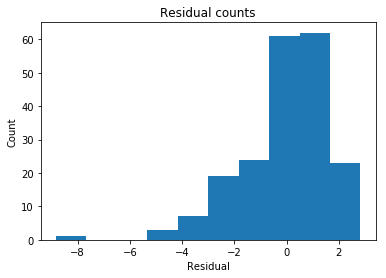

In [202]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

The histogram above is concerning because it is skewed to the left and the assumption necessary to build a good multivariate regression model is that the distribution is close to normal.  We attempt to correct this (see below).

## Building the new multivariate regression model
First, use log values to account for skewness above, but we also need to check for values equal to zero
which would yield an error in our log calculation.

In [203]:
# Log transform skewed data using this line of code (on the columns that needs to be transformed)
data['TV_log'] = data['TV'].apply(lambda x: np.log(x+0))
data['Newspaper_log'] = data['Newspaper'].apply(lambda x: np.log(x+0))
data['Radio_log'] = data['Radio'].apply(lambda x: np.log(x+0))

# Check wether we have some infinite values (see output further down)
print(data.index[np.isinf(data).any(1)])

# Apparently on index 127 we have an infinite value that would mess up our model
print(data.iloc[127])  # There we see that radio is inf...

# Instantiate and fit our model again using log values for just the tv data to see if we are
# getting closer to a normal distribution
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV_log', 'Radio', 'Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

Int64Index([127], dtype='int64')
TV              80.200
Radio            0.000
Newspaper        9.200
Sales            8.800
TV_log           4.385
Newspaper_log    2.219
Radio_log         -inf
Name: 127, dtype: float64

Coefficients: 
 [[ 3.93617857e+00  2.06700329e-01 -2.53093402e-03]]

Intercept: 
 [-9.09887557]

R-squared:
0.9066722324831502


Now, we can compare the predicted values vs actual values to determine if converting just the tv advertising to 
its log value normalizes the data.  We see in the histogram below, that this is much closer to a normal distribution.

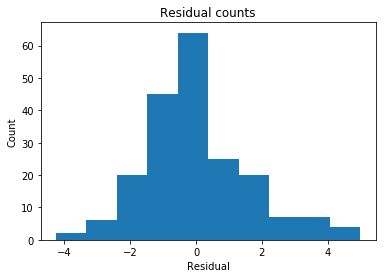

In [204]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

The new mv regression equation looks like:  **y = -9.1 +3.9(tv) + 0.2(radio) - .003(newspaper)**  The next assumption that needs to be addressed is skedasticity which we will look at using a scatterplot.

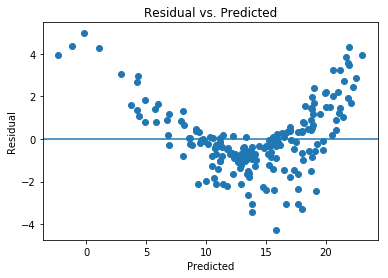

In [205]:
# creating a scatterplot
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

The above scatter plot looks like the error data is not consistently distibuted.  In other words, it is not homoskedastic.  Predictd values in the middle of the range (from 5 to 20) are too high because the residual (actual - predicted) have more negative values.  We need to transform the data in some way to make it more homoskedastic.  One way to do this is to take the log of the dependent variable or 'Sales' in this case.

In [206]:
# Log transform skewed data using this line of code (on the columns that needs to be transformed)
data['tv_log'] = data['TV'].apply(lambda x: np.log(x)) 
data['newpaper_log'] = data['Newspaper'].apply(lambda x: np.log(x))
data['radio_log'] = data['Radio'].apply(lambda x: np.log(x))

data['sales_log'] = data['Sales'].apply(lambda x: np.log(x)) 

# Instantiate and fit our model again using log values for just the tv data to see if we are
# getting closer to a normal distribution
regr = linear_model.LinearRegression()
Y = data['sales_log'].values.reshape(-1, 1)
X = data[['tv_log', 'Radio', 'Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[3.57050837e-01 1.33394947e-02 1.38055728e-04]]

Intercept: 
 [0.58128263]

R-squared:
0.9730806537777336


In [207]:
data.head()

,TV,Radio,Newspaper,Sales,TV_log,Newspaper_log,Radio_log,tv_log,newpaper_log,radio_log,sales_log
0,230.100,37.800,69.200,22.100,5.439,4.237,3.632,5.439,4.237,3.632,3.096
1,44.500,39.300,45.100,10.400,3.795,3.809,3.671,3.795,3.809,3.671,2.342
2,17.200,45.900,69.300,9.300,2.845,4.238,3.826,2.845,4.238,3.826,2.230
3,151.500,41.300,58.500,18.500,5.021,4.069,3.721,5.021,4.069,3.721,2.918
4,180.800,10.800,58.400,12.900,5.197,4.067,2.380,5.197,4.067,2.380,2.557


Now, let's look at the new histogram and scatterplot to see if we have satisfied both assumptions.

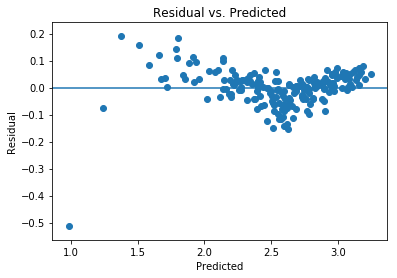

In [208]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['sales_log']

# Calculate the error, also called the residual.
residual = actual - predicted

# creating a new scatterplot
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


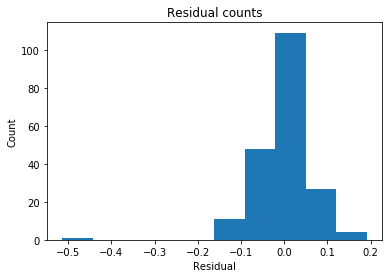

In [209]:
# check the histogram again to see if it is still close to normally distributed.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## Evaluating the model
This is much better.  The data is now more homoskedastic and we still have a fairly normal distribution.  The new multivariate regressin equation is (from our y-intercept and coeficients above):  
**y = .58 + .36(tv_advertising) + .013(radio_advertising) + .00014(newspaper_advertising)** 

## Discussion and Conclusion
In this model we constructed a multivariate equation for predicting toy sales from the amount we spent advertising on television, radio and in the newspaper.  The assumptions for building a valid multivariate model are:  
1.  Features need to have a linear relationship
2.  The error from the model needs to be normally distributed
3.  The distribution of error terms should be homoscedastic
4.  Correlations among features should be low or nonexistent
In this model we corrected for non-noramlity by taking the log of tv advertising.  We then corrected for heteroscedasticity by taking the log of the dependent variabl - in this case, toy sales.  The ultimate goal is to create an equation to predict toy sales and to use our advertising dollars wisely.  Since the coefficient for tv advertising is the largest, it is having more impact on sales than radio or newspaper.  

Finally, our R squared value - which represents how much variance in the outcome variable our model was able to explain - decreases as we satisfied the two assumptions.  It started out at .897, then moved to .907 when we corrected for normality, then moved to .973 after correcting for heteroscedasticity.  Since the value bacame so large on the last step, we may need to look at the possibility of our model suffering from overfitting for further research.